# Next Word Prediction- Encoder Decoder Structure




In [ ]:
!pip install portalocker
#!pip install torch==2.1.0
!nvcc --version
!pip freeze

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
absl-py==1.4.0
aiohttp==3.9.1
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.13.1
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.15.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.1
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.7
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0

In [ ]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as  optim


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            #In the case it will place the value of float("-1e30") at the positions where padding i.e. is equal to zero. Since k1 has singleton dimensions its shape will be broadcasted to the shape of p1.
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term) #for odd using sin: sin (pos*exp(-log(10000)*2i/d) ) = sin(pos/ (10000^{2i/d}))
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0)) #If you have parameters in your model, which should be saved and restored in the state_dict, but not trained by the optimizer, you should register them as buffers.

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]




In [ ]:
#Build encoder
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [ ]:
#Build decoder
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [ ]:
#Get Transformer
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)


criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

In [ ]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into ``bsz`` separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 64
eval_batch_size = 64
train_data_tmp = batchify(train_data, batch_size)  # shape ``[seq_len, batch_size]``
val_data_tmp = batchify(val_data, eval_batch_size)
test_data_tmp = batchify(test_data, eval_batch_size)




In [ ]:
#find vocab smaller than 12000
ind_train = torch.where(torch.all(train_data_tmp <= 12000, dim=1))
train_data = train_data_tmp[ind_train]

ind_val = torch.where(torch.all(val_data_tmp <= 12000, dim=1))
val_data = val_data_tmp[ind_val]

ind_test = torch.where(torch.all(test_data_tmp <= 12000, dim=1))
test_data = test_data_tmp[ind_test]


In [ ]:
test_data

tensor([[  568,  6812,   337,  ...,     9,     7,   998],
        [ 2462,    66,   528,  ...,   339,     3,   947],
        [   32,     1,   177,  ...,     0, 11874,  1443],
        ...,
        [   27,    15,     4,  ...,   940,   867,     1],
        [    1,     8,  2977,  ...,     1,   443,   456],
        [  176,   159,     1,  ...,    68,  4889,  4415]], device='cuda:0')

In [ ]:
torch.transpose(train_data, 0, 1).shape, torch.transpose(test_data, 0, 1).shape



(torch.Size([64, 2032]), torch.Size([64, 372]))

In [ ]:
src_vocab_size = 12000
tgt_vocab_size = 12000
test_vocab_size = 12000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1


transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout).to(device)

# Generate random sample data
#src_data = torch.transpose(train_data, 0, 1).to(device)
#tgt_data = torch.transpose(val_data, 0, 1).to(device)
# Generate random sample data
src_data = torch.transpose(train_data[:max_seq_length,], 0, 1).to(device) #100*64
tgt_data = torch.transpose(val_data[:max_seq_length,], 0, 1).to(device) #100*64
test_data = torch.transpose(test_data[:max_seq_length,], 0, 1).to(device) #100*64



criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001,  eps=1e-9)
#optimizer = optim.SGD(transformer.parameters(), lr=0.001)

transformer.train()

train_error = []
test_error = []
for epoch in range(101):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    train_error.append(loss.item())
    #Test
    test_output = transformer(src_data, test_data[:, :-1])
    test_loss = criterion(test_output.contiguous().view(-1, test_vocab_size), test_data[:, 1:].contiguous().view(-1))
    test_error.append(test_loss.item())

    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Test Loss:{test_loss.item()}")




Epoch: 1, Loss: 9.58538818359375, Test Loss:9.588404655456543
Epoch: 2, Loss: 8.609630584716797, Test Loss:8.679137229919434
Epoch: 3, Loss: 8.236505508422852, Test Loss:8.331199645996094
Epoch: 4, Loss: 8.059596061706543, Test Loss:8.157899856567383
Epoch: 5, Loss: 7.951573848724365, Test Loss:8.057432174682617
Epoch: 6, Loss: 7.870773792266846, Test Loss:7.987525939941406
Epoch: 7, Loss: 7.80679178237915, Test Loss:7.935410022735596
Epoch: 8, Loss: 7.750100135803223, Test Loss:7.890148162841797
Epoch: 9, Loss: 7.693870544433594, Test Loss:7.850893020629883
Epoch: 10, Loss: 7.637470245361328, Test Loss:7.810835361480713
Epoch: 11, Loss: 7.58176326751709, Test Loss:7.767576694488525
Epoch: 12, Loss: 7.522561073303223, Test Loss:7.727179050445557
Epoch: 13, Loss: 7.467076778411865, Test Loss:7.686954021453857
Epoch: 14, Loss: 7.411797046661377, Test Loss:7.645732879638672
Epoch: 15, Loss: 7.355970859527588, Test Loss:7.6077446937561035
Epoch: 16, Loss: 7.301466941833496, Test Loss:7.568

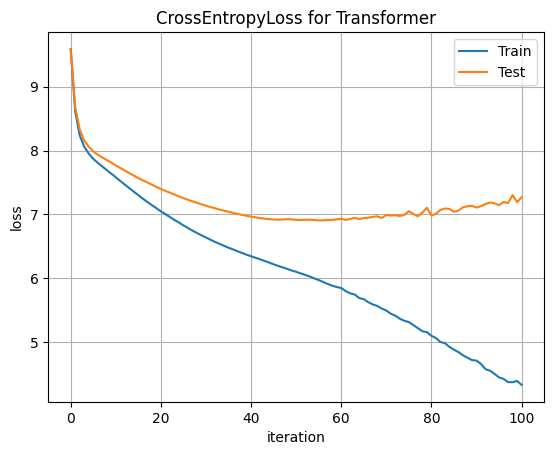

In [ ]:
import matplotlib.pyplot as plt


plt.plot(train_error, label='Train')
plt.plot(test_error, label='Test')
plt.title('CrossEntropyLoss for Transformer')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()